## Imports

In [53]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler

import warnings

# Suprimir todos os warnings
warnings.filterwarnings("ignore")

In [49]:
PALETTE = 'YlGnBu'
COLOR = 'gray'
EDGE = 'black'
DPI = 120

## Dataset

In [8]:
df = pd.read_csv('df_processed.csv')
df.head()

,General_Health,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Height_(cm),...,Age_Category_35-39,Age_Category_40-44,Age_Category_45-49,Age_Category_50-54,Age_Category_55-59,Age_Category_60-64,Age_Category_65-69,Age_Category_70-74,Age_Category_75-79,Age_Category_80+
0,1,0,0,0,0,0,0,1,1,150.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,4,0,1,0,0,0,1,0,1,165.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,4,1,0,0,0,0,1,0,1,163.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1,1,0,0,0,1,0,0,180.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3,0,0,0,0,0,0,0,0,191.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
df.shape

(308854, 35)

In [ ]:
print(df.columns.tolist())

## Modelagem


In [10]:
R_STATE = 42
TARGET = 'Heart_Disease'

In [11]:
def model_train_test(df: pd.DataFrame, target: str, test_size=0.3, random_state=42) -> list:
    X, y = df.drop(columns=target), df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state
    )

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = model_train_test(df, TARGET)

In [29]:
# Balanceamento (3:1)
sampling_strategy = {0: y_train.value_counts()[1] * 3}

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=R_STATE)

X_train_processed, y_train_processed = rus.fit_resample(X_train, y_train)

print(y_train_resampled.value_counts())

Heart_Disease
0    52245
1    17415
Name: count, dtype: int64


### Supervisionada

In [16]:
PARAM_GRID_XGB = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'subsample': [0.6, 0.8, 1.0]
}

PARAM_GRID_ADABOOST = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1, 10],
}

PARAM_GRID_LGBM = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7, -1],
    'num_leaves': [31, 50, 100],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

In [36]:
def supervised_rand_search_cv(model, param_grid, X_train, X_test, y_train, y_test, cv=5, n_jobs=-1, verbose=1):
    rand_search = RandomizedSearchCV(
        model,
        param_grid,
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose
    )

    rand_search.fit(X_train, y_train)

    best_model = rand_search.best_estimator_
    predictions = best_model.predict(X_test)
    recall = recall_score(predictions, y_test)

    print(f'Melhores parâmetros: {rand_search.best_params_}')
    print(f'Recall: {recall}')

    return best_model

In [31]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', class_weight='balanced')
adaboost_model = AdaBoostClassifier(random_state=R_STATE)
LGBM_model = lgb.LGBMClassifier(random_state=R_STATE, objective='binary', class_weight='balanced')

### XGBoost

In [37]:
best_xgb_model = supervised_rand_search_cv(xgb_model, PARAM_GRID_XGB, X_train_processed, X_test, y_train_processed, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhores parâmetros: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
Recall: 0.3143123543123543


### Adaboost

In [38]:
best_adaboost_model = supervised_rand_search_cv(adaboost_model, PARAM_GRID_ADABOOST, X_train_processed, X_test, y_train_processed, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhores parâmetros: {'n_estimators': 100, 'learning_rate': 1}
Recall: 0.3143935727422321


### LGBM

In [39]:
best_LGBM_model = supervised_rand_search_cv(LGBM_model, PARAM_GRID_LGBM, X_train_processed, X_test, y_train_processed, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17415, number of negative: 52245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 69660, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Melhores parâmetros: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'num_leaves': 50, 'n_estimators': 500, 'min_child_samples': 100, 'max_depth': -1, 'learning_rate': 0.5, 'colsample_bytree': 1.0}
Recall: 0.21029358132749817


In [44]:
def cm_roc_recall_plot(model_name, model, X_train, X_test, y_train, y_test) -> None:
    paleta = sns.color_palette(PALETTE)

    pipeline = Pipeline(steps=[
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    print(f'{model_name} \n{classification_report(y_test, y_pred)}')
    print(f'ROC AUC score: {roc_auc_score(y_test, y_pred_proba):.4f}')

    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    plt.suptitle(f'Métricas para o modelo {model_name}')

    cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=PALETTE, colorbar=False, ax=ax[0])
    ax[0].set_title('Matriz de Confusão - Dados de Teste', fontsize=10)
    ax[0].set_xlabel('Rótulos Preditos')
    ax[0].set_ylabel('Rótulos Reais')

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    ax[1].set_title('Curva ROC-AUC', fontsize=10)
    ax[1].plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})', color=paleta[4])
    ax[1].plot([0, 1], [0, 1], 'k--', label='Linha aleatória (AUC = 0.5)', color = 'gray')
    ax[1].set_xlabel('Taxa de Falsos Positivos (FPR)')
    ax[1].set_ylabel('Taxa de Verdadeiros Positivos (TPR)')
    ax[1].legend(loc='lower right')
    ax[1].grid(alpha =.25)

    precision, recall, _ = precision_recall_curve(y_pred, y_pred_proba)
    ax[2].set_title('Curva Precisão-recall', fontsize=10)
    ax[2].plot(recall, precision, label='Curva de precision-recall', color=paleta[4])
    ax[2].set_xlabel('Recall')
    ax[2].set_ylabel('Precisão')
    ax[2].legend(loc='best')
    ax[2].grid(alpha =.25)

    plt.tight_layout()
    plt.figure(dpi=DPI)
    plt.show()


ADAboost 
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     85101
           1       0.31      0.43      0.36      7556

    accuracy                           0.88     92657
   macro avg       0.63      0.67      0.65     92657
weighted avg       0.90      0.88      0.89     92657

ROC AUC score: 0.8364


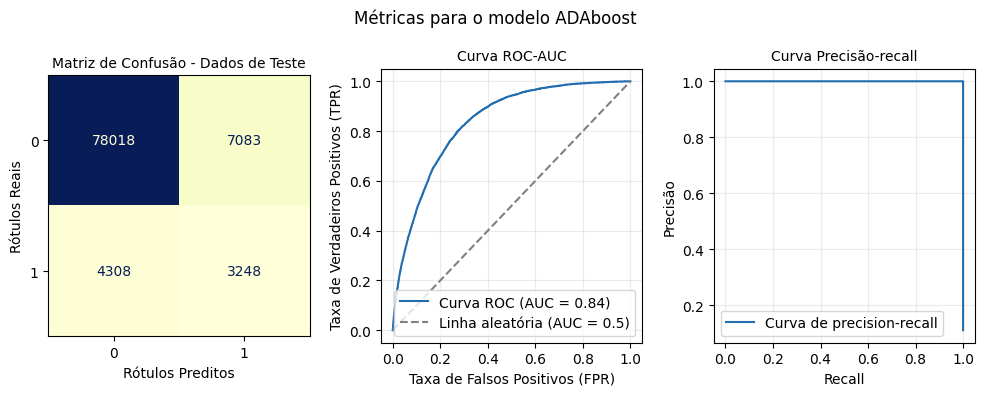

<Figure size 768x576 with 0 Axes>

In [54]:
cm_roc_recall_plot("ADAboost", best_adaboost_model, X_train_processed, X_test, y_train_processed, y_test)

XGBoost 
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     85101
           1       0.31      0.45      0.37      7556

    accuracy                           0.88     92657
   macro avg       0.63      0.68      0.65     92657
weighted avg       0.90      0.88      0.89     92657

ROC AUC score: 0.8368


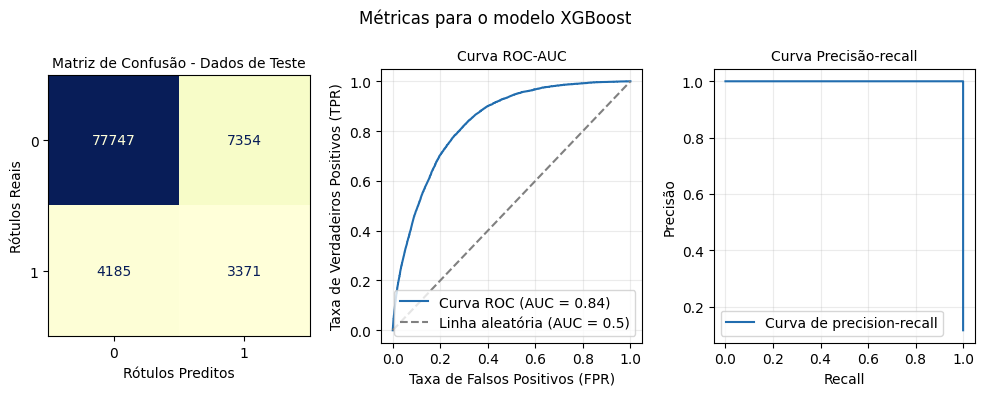

<Figure size 768x576 with 0 Axes>

In [55]:
cm_roc_recall_plot("XGBoost", best_xgb_model, X_train_processed, X_test, y_train_processed, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17415, number of negative: 52245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 69660, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
LGBM 
              precision    recall  f1-score   support

           0       0.96      0.80      0.87     85101
           1       0.21      0.61      0.31      7556

    accuracy                           0.78     92657
   macro avg       0.58      0.70      0.59     92657
weighted avg       0.90      0.78      0.82     92657

ROC AUC score: 0.7941


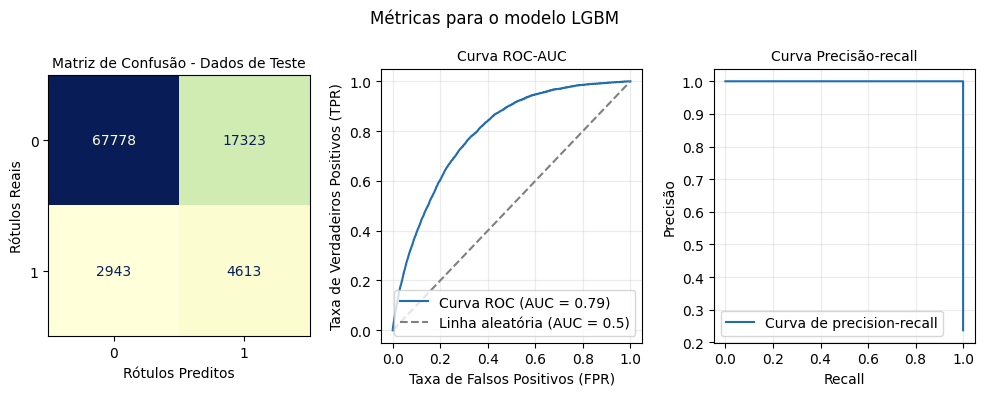

<Figure size 768x576 with 0 Axes>

In [56]:
cm_roc_recall_plot("LGBM", best_LGBM_model, X_train_processed, X_test, y_train_processed, y_test)

### Não supervisionada

In [57]:
PARAM_GRID_KMEANS = {
    'n_clusters': [2, 3, 5, 10],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 30],
    'max_iter': [300, 500]
}

In [58]:
def unsupervised_rand_search_cv(model, param_grid, df, cv=5, n_jobs=-1, verbose=1):
    rand_search = RandomizedSearchCV(
        model,
        param_grid,
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose
    )

    rand_search.fit(X_train)
    best_model = rand_search.best_estimator_

    print(f'Melhores parâmetros: {rand_search.best_params_}')

    return best_model

In [59]:
kmeans_model = KMeans(random_state=R_STATE)

### Kmeans

In [ ]:
best_kmeans_model = unsupervised_rand_search_cv(kmeans_model, PARAM_GRID_KMEANS, df)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
